<a href="https://colab.research.google.com/github/Cirrusfloccus31/MiniProjets_HDDL/blob/main/MP4_HDDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HDDL : Mini-projet 4 RNN, LSTM and GRU vs MLP and CNN

Paul Lacotte, Ariadna Perellò, Oriane Caputo, Hugo Germain

L'objectif de ce projet est d'évaluer et de **comparer** l'efficacité de **différents modèles d'apprentissage** pour une tâche de classification binaire basée sur des données textuelles. Plus précisément, nous cherchons à prédire les sentiments (positifs ou négatifs) exprimés dans les textes du jeu de données *IMDB*.

# I) Chargement des données

On télécharge et extrait le jeu de données IMDB, qui est déjà séparé en ensembles d’entraînement et de test. On charge les critiques positives et négatives avec leurs étiquettes. Puis on convertit les données en DataFrames contenant le texte et son étiquette ('pos' ou 'neg').

In [ ]:
import os
import pandas as pd
import numpy as np
import numpy.random as random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Étape 1 : Télécharger et extraire les données IMDB
if not os.path.exists("aclImdb_v1.tar.gz"):
    !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
if not os.path.exists("aclImdb"):
    !tar -xzf aclImdb_v1.tar.gz

# Étape 2 : Charger les données brutes
def load_imdb_data(path):
    data = []
    for label in ['pos', 'neg']:
        for filename in os.listdir(os.path.join(path, label)):
            with open(os.path.join(path, label, filename), 'r', encoding='utf-8') as f:
                text = f.read()
                data.append([text, label])  # 'pos' ou 'neg'
    return data

# Charger les ensembles d'entraînement et de test
train_data = load_imdb_data('aclImdb/train')
test_data = load_imdb_data('aclImdb/test')

# Convertir en DataFrames
train_df = pd.DataFrame(train_data, columns=['text', 'label'])
test_df = pd.DataFrame(test_data, columns=['text', 'label'])

print("Exemple de données d'entraînement :")
print(train_df.head())

print(f"Taille des données d'entraînement : {train_df.shape}")
print(f"Taille des données de test : {test_df.shape}")


--2024-12-19 17:31:59--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... 

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  4.20MB/s    in 35s     

2024-12-19 17:32:34 (2.32 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Exemple de données d'entraînement :
                                                text label
0  One of the best movies for all ages. You will ...   pos
1  What a good film! Made Men is a great action m...   pos
2  This is the movie for those who believe cinema...   pos
3  Lensman is a rather lesser-known Anime gem fro...   pos
4  I almost didn't rent this because of all the b...   pos
Taille des données d'entraînement : (25000, 2)
Taille des données de test : (25000, 2)


## Pré-traitement des données

**Processus de tokenization** : Le tokenizer  crée un **vocabulaire des 10 000 mots** les plus fréquents à partir des critiques d'entraînement. Il convertit ensuite chaque texte en une **séquence d'entiers**, chaque entier représentant un mot spécifique. Les mots les moins fréquents sont remplacés par le token spécial "**OOV**"(out of vocabulry). "OOV" permet au modèle de continuer à traiter des textes avec des mots qui n'ont pas été vus lors de l'entraînement sans provoquer d'erreur.

On a décidé de limiter aux **10 000  mots** les plus fréquents pour **diminuer la complexité** du modèle mais en conservant les caractéristiques importantes.

**Padding et Truncation** : Pour garantir que toutes les séquences ont la même longueur, chaque texte est tronqué ou rempli avec des zéros à une longueur maximale de 200 mots.

**Conversion des étiquettes en valeurs binaires** : 1 pour positif et 0 pour negatif.

Puis on enregistre ces données préparées dans le fichier *imdb_prepared.npz*.

In [ ]:
vocab_size = 10000
maxlen = 200

# Tokenisation et conversion des textes en séquences
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

x_train = tokenizer.texts_to_sequences(train_df['text'])
x_test = tokenizer.texts_to_sequences(test_df['text'])

# Troncature et padding pour uniformiser la longueur des séquences
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')


# Conversion
y_train = np.array([1 if label == 'pos' else 0 for label in train_df['label']])
y_test = np.array([1 if label == 'pos' else 0 for label in test_df['label']])

print(f"Taille des données d'entraînement : {x_train.shape}, {y_train.shape}")
print(f"Taille des données de test : {x_test.shape}, {y_test.shape}")
print("Exemple de séquence tokenisée (x_train[0]) :")
print(x_train[0])
print("Label correspondant :", y_train[0])

# Enregistrement
np.savez_compressed("imdb_prepared.npz", x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
print("Les données préparées ont été enregistrées sous 'imdb_prepared.npz'.")


Taille des données d'entraînement : (25000, 200), (25000,)
Taille des données de test : (25000, 200), (25000,)
Exemple de séquence tokenisée (x_train[0]) :
[  29    5    2  116  100   16   30 2079   23   78  113   28  500    6
  166   31 3071  709  172  207  534    5    2 1725  477   12   18 1606
  752 1671  151  152   11  294   12   17   59  320    3  105 3185  101
  155 4484   11   26   22 1496  507    4   18   36   74    9    4  194
   56    8    8  191   56   44    3  104   12   17    2  360   10   78
 3023   23    5   87  907  341    6   28   52   23   69    4  183   29
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

# II) Construction des modèles

On fait face à un problème de classification binaire, on choisit donc une loss 'binary_crossentropy' et une fonction d'activation de sortie 'sigmoid'.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Flatten, Dropout, Activation, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
seed_value = 10
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)


In [ ]:
# Charger les données prétraitées
data = np.load("imdb_prepared.npz")
x_train, y_train = data['x_train'], data['y_train']
x_test, y_test = data['x_test'], data['y_test']

batch_size = 64
epochs = 10

## 1) RNN

On met en place un **RNN simple** avec une **couche d'embedding** suivie d'une **couche récurrente** et de **couches entièrement connectées**. Le RNN est adapté pour les **données séquentielles** telles que les données textuelles du dataset.

On utilise une fonction d'activation **ReLU** afin d'introduire de la **non-linéarité** et essayer d'éviter le **vanishing gradient** (problème courant des RNN).


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5047 - loss: 0.6947 - val_accuracy: 0.5078 - val_loss: 0.6924
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.6333 - loss: 0.6165 - val_accuracy: 0.5090 - val_loss: 0.7314
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.6836 - loss: 0.4977 - val_accuracy: 0.5137 - val_loss: 0.8994
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.7225 - loss: 0.4115 - val_accuracy: 0.5142 - val_loss: 1.0892
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.7357 - loss: 0.3831 - val_accuracy: 0.5148 - val_loss: 1.2816
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7527 - loss: 0.3640 - val_accuracy: 0.5120 - val_loss: 1.5121
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.7534 - loss: 0.3744 - val_accuracy: 0.5128 - val_loss: 1.3928
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.7601 - loss: 0.3628 - 

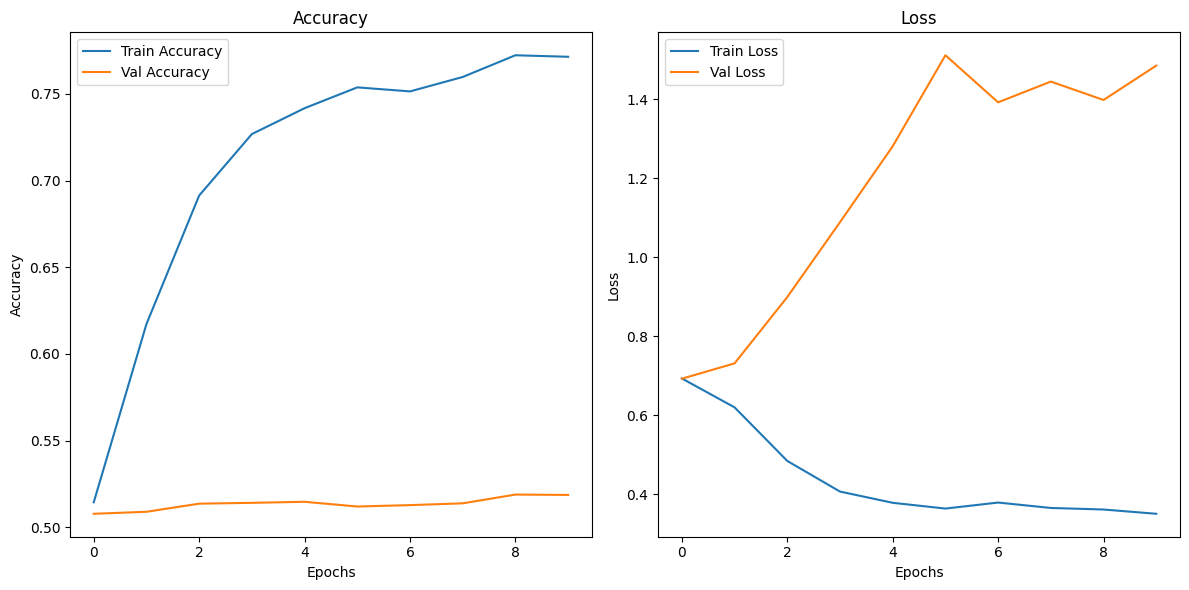

In [ ]:
embedding_dim = 400
lr = 10e-4
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim, input_length=maxlen),
        SimpleRNN(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_history = rnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

test_loss, test_acc = rnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print(f"RNN Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

On peut remarquer directement que le RNN simple est sur-entrainé et peu précis en test. Il faudrait essayer de rajouter un early stopping ainsi que du dropping pour éviter le sur-entrainement et de rajouter une normalisation L2 pour tenter de mieux généraliser sur les données de test.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.5040 - loss: 0.6941 - val_accuracy: 0.5561 - val_loss: 0.6867 - learning_rate: 5.0000e-04
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5790 - loss: 0.6655 - val_accuracy: 0.5260 - val_loss: 0.6895 - learning_rate: 5.0000e-04
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6557 - loss: 0.5619 - val_accuracy: 0.5084 - val_loss: 0.7220 - learning_rate: 5.0000e-04
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.7015 - loss: 0.4733 - val_accuracy: 0.5020 - val_loss: 0.7982 - learning_rate: 5.0000e-04
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4126 - loss: 0.7193
RNN Test Accuracy: 0.5561, Test Loss: 0.6867


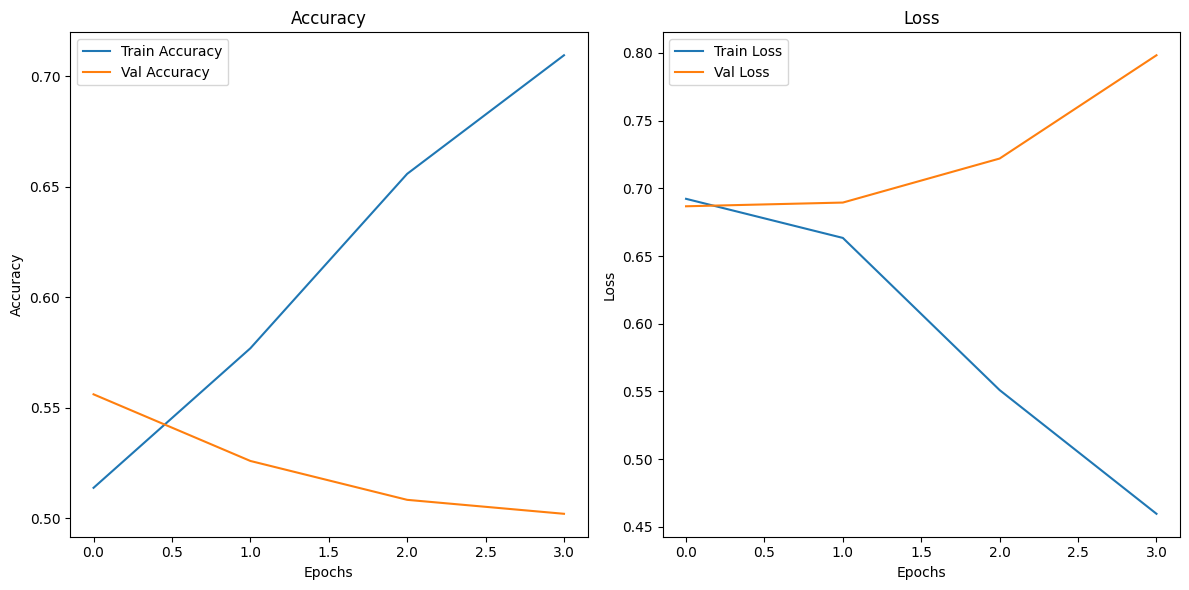

In [ ]:
embedding_dim = 400


early_stopping = EarlyStopping(
    monitor='val_loss',patience=3, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6 # Adapte la learning rate en fonction de l'évolution des paramètres de l'entrainement.
)

def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim, input_length=maxlen),
        SimpleRNN(64, return_sequences=False, dropout=0.5),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_history = rnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size,callbacks=[early_stopping,reduce_lr])

test_loss, test_acc = rnn_model.evaluate(x_test, y_test, batch_size=batch_size)
print(f"RNN Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

On a observé un résultat similmaire à celui de début lorsque l'on a introduit régularisation et dropout en même temps alors que l'un et l'autre séparés donnaient des resultats légèrement meilleurs que le RNN simple. Sur ce plot on a donc décidé de ne garder que la régularisation.

**Performance globale** : Une précision de test à 56% montre que le modèle est peu performant, loin d'être optimal, on observe toujours beaucoup d'overfitting. Le problème vient du fait que pour le RNN plus les séquences sont longues plus le modèle est capable de s'adapter à des motifs spécifiques et donc tend vers un sur entrainement. Son incapacité à capturer les dépendances à long termes est aussi un facteur de moins bonnes performances.

Les architectures plus avancées telles que LSTM et GRU permettront sûrement de réduire le sur-apprentissage et d'améliorer les performances en évitant le problème classique du RNN de vanishing gradient et ceux cités plus haut.

## 2) LSTM

On décide d'entreprendre la même démarche, c'est à dire partir d'un LSTM basique puis essayer d'améliorer l'accuracy. Par défaut, la fonction d'activation utilisée dans la couche LSTM de keras que nous avons utilisée est tangente hyperbolique, ce qui est classiquement bien adapté aux LSTMs.

In [ ]:
embedding_dim = 400

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5579 - loss: 0.6779 - val_accuracy: 0.6662 - val_loss: 0.6397
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6145 - loss: 0.6447 - val_accuracy: 0.8294 - val_loss: 0.3992
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8672 - loss: 0.3238 - val_accuracy: 0.8422 - val_loss: 0.3760
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9277 - loss: 0.1985 - val_accuracy: 0.8496 - val_loss: 0.4232
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9558 - loss: 0.1356 - val_accuracy: 0.8420 - val_loss: 0.4924
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9721 - loss: 0.0959 - val_accuracy: 0.8370 - val_loss: 0.5900
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9754 - loss: 0.0818 - val_accuracy: 0.8413 - val_loss: 0.6192
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9869 - loss: 0.0499 - val_acc

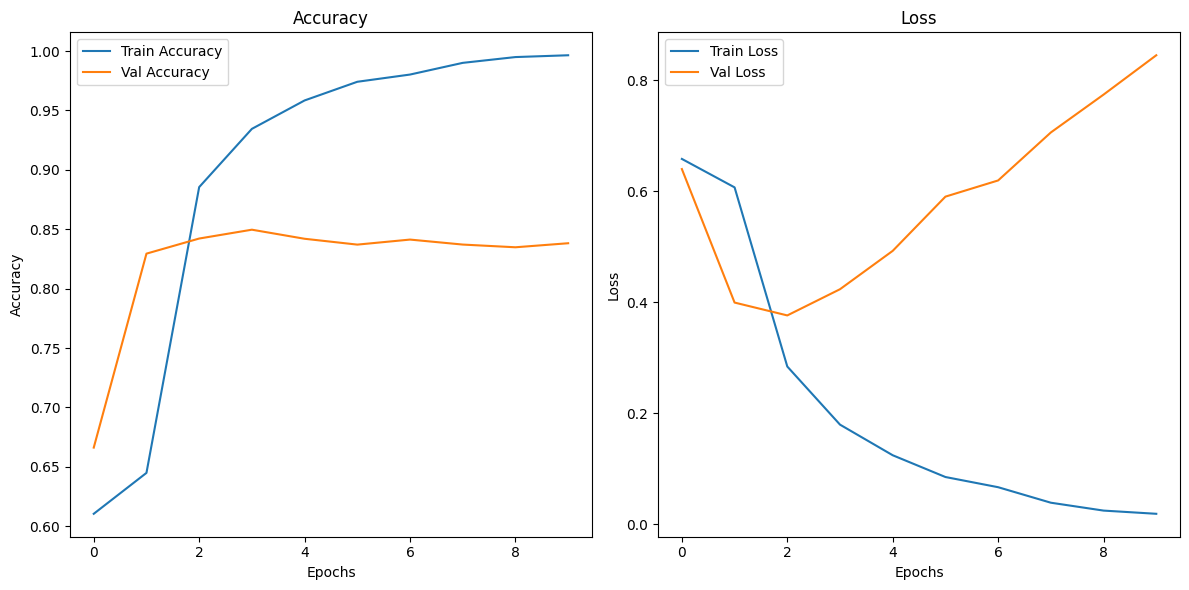

In [ ]:
model_single_lstm = Sequential()
model_single_lstm.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200))
model_single_lstm.add(LSTM(64))  # Single LSTM Layer
model_single_lstm.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile model
model_single_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_single_lstm.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

# Evaluate the model

loss, accuracy = model_single_lstm.evaluate(x_test, y_test)
print(f"Single-Layer LSTM Test Accuracy: {accuracy}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Autour de 5 epochs on observe une accuracy de validation qui stagne ainsi qu'un écart important entre les courbes de loss qui témoigne d'un surentrainement.

L'idéal serait d'arriver à limiter le sur-entrainement tout un gardant un nombre d'époques un peu plus élevé que 5 pour essayer d'améliorer encore les performances du modèle sur des valeurs de test.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5247 - loss: 0.6932 - val_accuracy: 0.5738 - val_loss: 0.6634
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5644 - loss: 0.6680 - val_accuracy: 0.5780 - val_loss: 0.6548
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6194 - loss: 0.6286 - val_accuracy: 0.8101 - val_loss: 0.4346
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8613 - loss: 0.3579 - val_accuracy: 0.8412 - val_loss: 0.3769
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9184 - loss: 0.2381 - val_accuracy: 0.8446 - val_loss: 0.4348
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8548 - loss: 0.3258
Single-Layer LSTM Test Accuracy: 0.8411999940872192


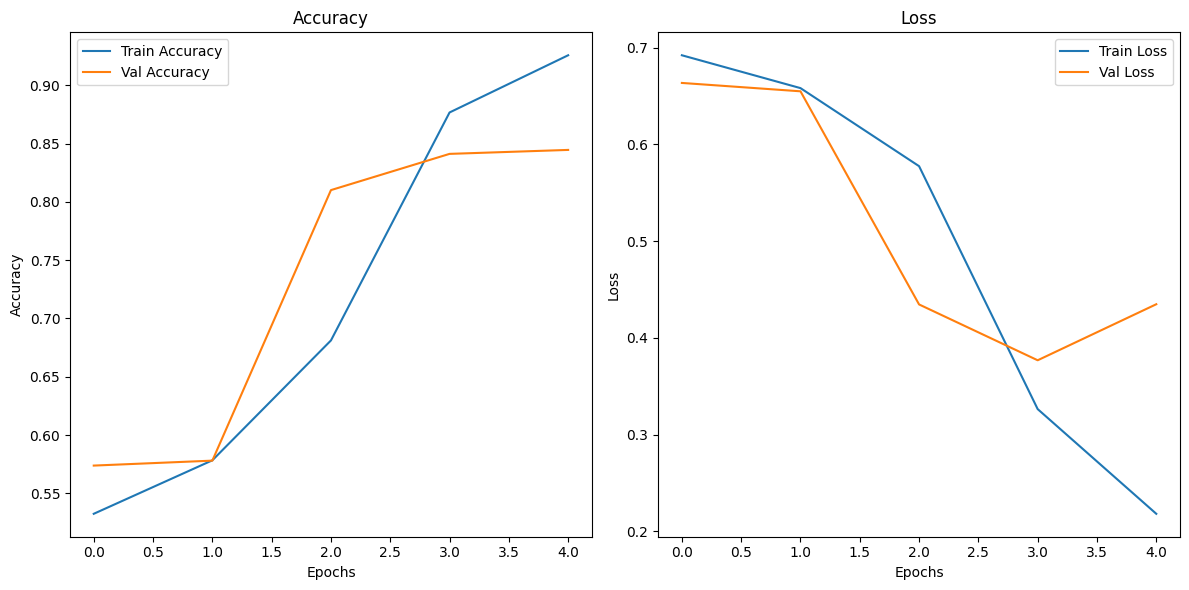

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',patience=1, restore_best_weights=True
)


model_single_lstm = Sequential()
model_single_lstm.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200))
model_single_lstm.add(LSTM(64))   # Ajout d'une couche de dropout
model_single_lstm.add(Dropout(0.5))
model_single_lstm.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile model
model_single_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_single_lstm.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test),callbacks=[early_stopping])

# Evaluate the model

loss, accuracy = model_single_lstm.evaluate(x_test, y_test)
print(f"Single-Layer LSTM Test Accuracy: {accuracy}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Remarque: là où on observe une légère amélioration avec le Dropout, on constate que l'ajout d'un kernel_regularizer dans la couche LSTM empire grandement pour une regul.L2 ainsi qu'une régul.L1. L'ajout de la régularisation L1L2 n'apporte cependant aucune amélioration significative.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5227 - loss: 0.6905 - val_accuracy: 0.5145 - val_loss: 0.6915
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6069 - loss: 0.6382 - val_accuracy: 0.8214 - val_loss: 0.4175
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8532 - loss: 0.3585 - val_accuracy: 0.8438 - val_loss: 0.3704
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9116 - loss: 0.2381 - val_accuracy: 0.8452 - val_loss: 0.4467
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8770 - loss: 0.3389
Single-Layer LSTM Test Accuracy: 0.8438000082969666


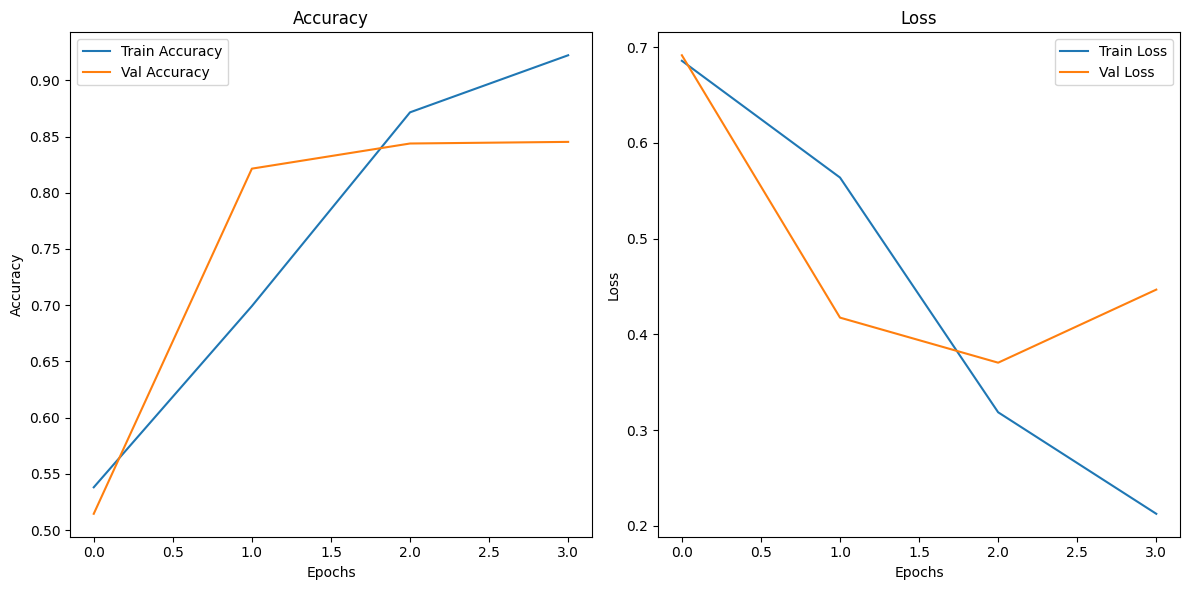

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',patience=1, restore_best_weights=True
)


model_single_lstm = Sequential()
model_single_lstm.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200))
model_single_lstm.add(LSTM(64,kernel_regularizer=tf.keras.regularizers.L1L2))
model_single_lstm.add(Dropout(0.2))
model_single_lstm.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile model
model_single_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_single_lstm.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test),callbacks=[early_stopping])

# Evaluate the model

loss, accuracy = model_single_lstm.evaluate(x_test, y_test)
print(f"Single-Layer LSTM Test Accuracy: {accuracy}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Comme on l'avait vu on observe que l'Early Stopping nous arrête à la 6ème epochs, on obtient une légère amélioration dans l'accuracy de test en combinant Dropout et Early Stopping.

Il semblerait donc que l'architecture optimale basée sur nos différents essais soit celle comprenant un Early Stopping, une couche de Dropout et un ElasticNet dans la couche LSTM.

**Performance globale** : On observe une précision plus élevée et une perte plus faible que pour le RNN, ce qui prouve la capacité du LSTM à mieux gérer les séquences longues grâce à ses portes (cellules mémoire). Quant à la structure du LSTM, après avoir essayé en plus d'ajouter une deuxième couche LSTM, notre meilleur modèle reste le dernier présenté.

## 3) GRU

Tout comme le LSTM, le GRU présente des avantages par rapport aux RNN, notamment sur le contrôle de l'apprentissage grâce aux **portes logiques**. Son architecture toutefois est **plus légère que LSTM** puisqu'il possède 2 portes et non 3.

Nous commençons par entraîner un modèle basique (une couche d'embedding, un GRU et une couche dense pour la classification binaire). Nous utilisons la couche de GRU de proposée dans Keras, qui utilise une fonction d'activation tangente hyperbolique par défaut.

Nous fixons le learning rate à 0.0005.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5083 - loss: 0.6927 - val_accuracy: 0.5766 - val_loss: 0.6772
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6741 - loss: 0.6134 - val_accuracy: 0.7289 - val_loss: 0.5590
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7176 - loss: 0.5547 - val_accuracy: 0.7510 - val_loss: 0.5468
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8105 - loss: 0.4557 - val_accuracy: 0.7949 - val_loss: 0.4711
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8436 - loss: 0.3875 - val_accuracy: 0.8146 - val_loss: 0.4326
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8794 - loss: 0.3109 - val_accuracy: 0.8310 - val_loss: 0.4085
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9112 - loss: 0.2452 - val_accuracy: 0.8330 - val_loss: 0.4077
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9314 - loss: 0.2016 - val_accu

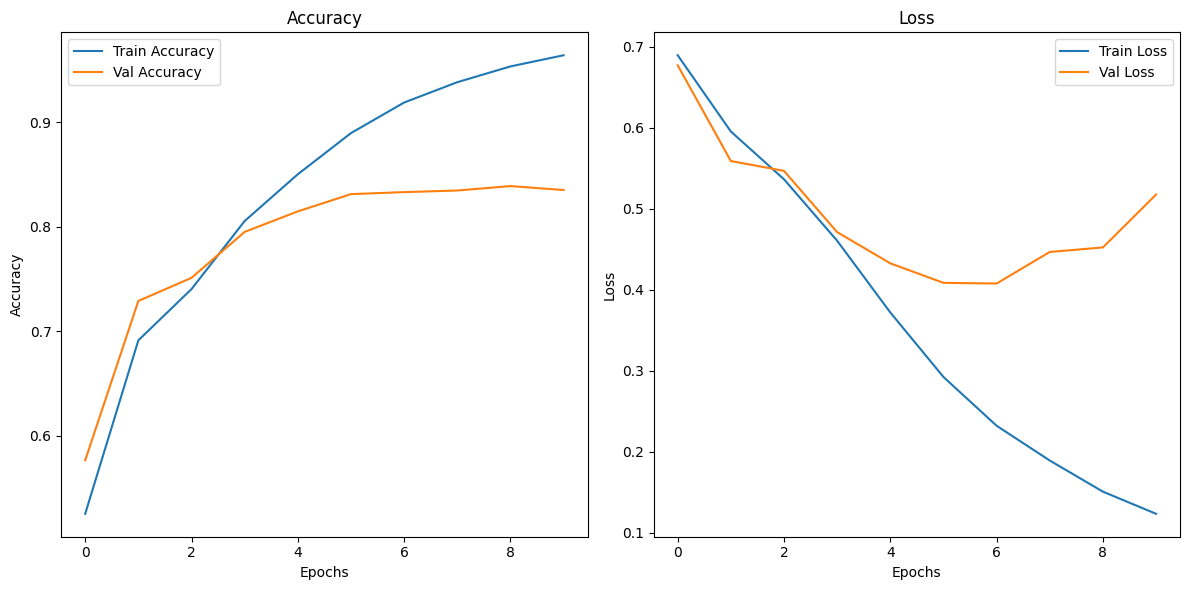

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def build_gru_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200),
        GRU(64, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

embedding_dim = 256
learning_rate = 0.0005
gru_model = build_gru_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
gru_history = gru_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

test_loss, test_acc = gru_model.evaluate(x_test, y_test, batch_size=32)
print(f"GRU Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Nous obtenons une précision de test de 83%. La loss de validation remonte dès la 5ème epoch et le généralisation gap est important, ce qui indique que le modèle sur-apprend. Nous décidons donc d'appliquer un dropout de 50% et de faire de l'early stopping.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5078 - loss: 0.6932 - val_accuracy: 0.5219 - val_loss: 0.6913
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5778 - loss: 0.6697 - val_accuracy: 0.7675 - val_loss: 0.5385
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6863 - loss: 0.6176 - val_accuracy: 0.8214 - val_loss: 0.4051
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8722 - loss: 0.3288 - val_accuracy: 0.8510 - val_loss: 0.3668
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9175 - loss: 0.2302 - val_accuracy: 0.8422 - val_loss: 0.3985
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9471 - loss: 0.1693 - val_accuracy: 0.8508 - val_loss: 0.4971
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8901 - loss: 0.2704
GRU Test Accuracy: 0.8510, Test Loss: 0.3668


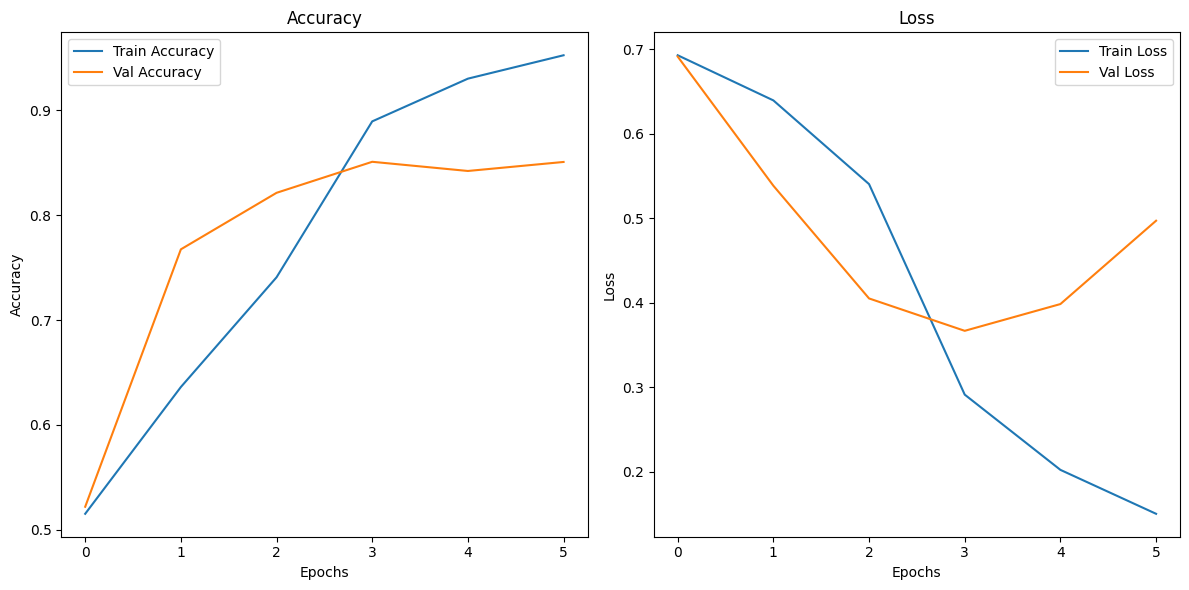

In [ ]:
def build_gru_model():
    dropout_rate = 0.5

    model_gru = Sequential()
    model_gru.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200))
    model_gru.add(GRU(64, return_sequences=False))   # Ajout d'une couche de dropout
    model_gru.add(Dropout(dropout_rate, seed=seed_value))
    model_gru.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model_gru.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model_gru

early_stopping = EarlyStopping(
    monitor='val_loss', restore_best_weights=True, patience=2
)
embedding_dim = 256
learning_rate = 0.0005
gru_model = build_gru_model()
gru_history = gru_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, callbacks = early_stopping)

test_loss, test_acc = gru_model.evaluate(x_test, y_test, batch_size=32)
print(f"GRU Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)

plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


L'ajout d'un dropout et d'early stopping permet d'améliorer l'accuracy et de diminuer l'overfitting. Nous décidons maintenant d'utiliser un GRU bidirectionnel, composé de deux GRUs indépendants. Chaque GRU parcourt la séquence d'input dans un sens (respectivement du premier mot au dernier et du dernier au premier). Ceci qui permet de garder les informations des tokens précédents et suivants, et donc de mieux comprendre le contexte.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.6034 - loss: 0.6334 - val_accuracy: 0.8240 - val_loss: 0.4004
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8629 - loss: 0.3338 - val_accuracy: 0.8463 - val_loss: 0.3726
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9074 - loss: 0.2542 - val_accuracy: 0.8142 - val_loss: 0.4261
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8597 - loss: 0.3620
GRU Test Accuracy: 0.8463, Test Loss: 0.3726


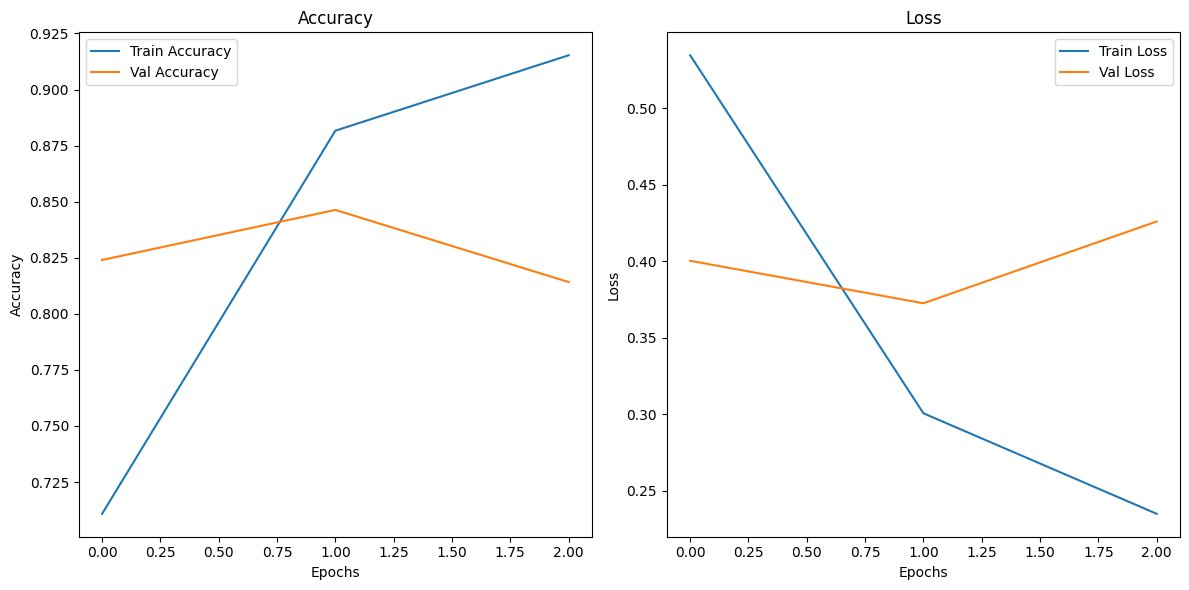

In [ ]:
from tensorflow.keras.layers import Bidirectional

def build_gru_model():
    dropout_rate = 0.5
    model_gru = Sequential()
    model_gru.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200))
    model_gru.add(Bidirectional(GRU(64, return_sequences=False)))
    model_gru.add(Dropout(dropout_rate, seed=seed_value))
    model_gru.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model_gru.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model_gru


early_stopping = EarlyStopping(
    monitor='val_loss', restore_best_weights=True, patience=1
)

embedding_dim = 256
learning_rate = 0.0005
gru_model = build_gru_model()
gru_history = gru_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, callbacks = early_stopping)

test_loss, test_acc = gru_model.evaluate(x_test, y_test, batch_size=32)
print(f"GRU Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Cette solution n'améliore pas la précision de test. Nous décidons alors de suivre une architecture proposée par Moh. Ainur Rohman sur Kaggle (https://www.kaggle.com/code/ainurrohmanbwx/bi-gru-with-attention-on-sentiment-analysis): nous ajoutons une couche d'attention globale à la sortie du GRU bidirectionnel, puis une couche dense à 64 neurones (activation: relu), un dropout de 50% et une deuxième couche dense à 32 neurones (activation: relu) avant la couche de sortie. La couche d'attention globale permet au réseau d'identifier les parties les plus importantes de l'input. Nous avons repris la classe proposée pour la construire.

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow import keras
class AttentionLayer(Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True


    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None


    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        # Use tf.reshape instead of K.reshape
        eij = tf.reshape(
            tf.matmul(
                tf.reshape(x, (-1, features_dim)),
                tf.reshape(self.W, (features_dim, 1))
            ),
            (-1, step_dim)
        )

        if self.bias:
            eij += self.b

        eij = tf.tanh(eij)
        a = tf.exp(eij)

        if mask is not None:
            a *= tf.cast(mask, tf.float32)

        a /= tf.cast(tf.reduce_sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.float32)
        a = tf.expand_dims(a, axis=-1)
        weighted_input = x * a

        return tf.reduce_sum(weighted_input, axis=1)



    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.6604 - loss: 0.5779 - val_accuracy: 0.8643 - val_loss: 0.3142
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8915 - loss: 0.2708 - val_accuracy: 0.8603 - val_loss: 0.3363
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9266 - loss: 0.2004 - val_accuracy: 0.8541 - val_loss: 0.3738
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9476 - loss: 0.1501 - val_accuracy: 0.8570 - val_loss: 0.3741
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8824 - loss: 0.2907
GRU Test Accuracy: 0.8643, Test Loss: 0.3142


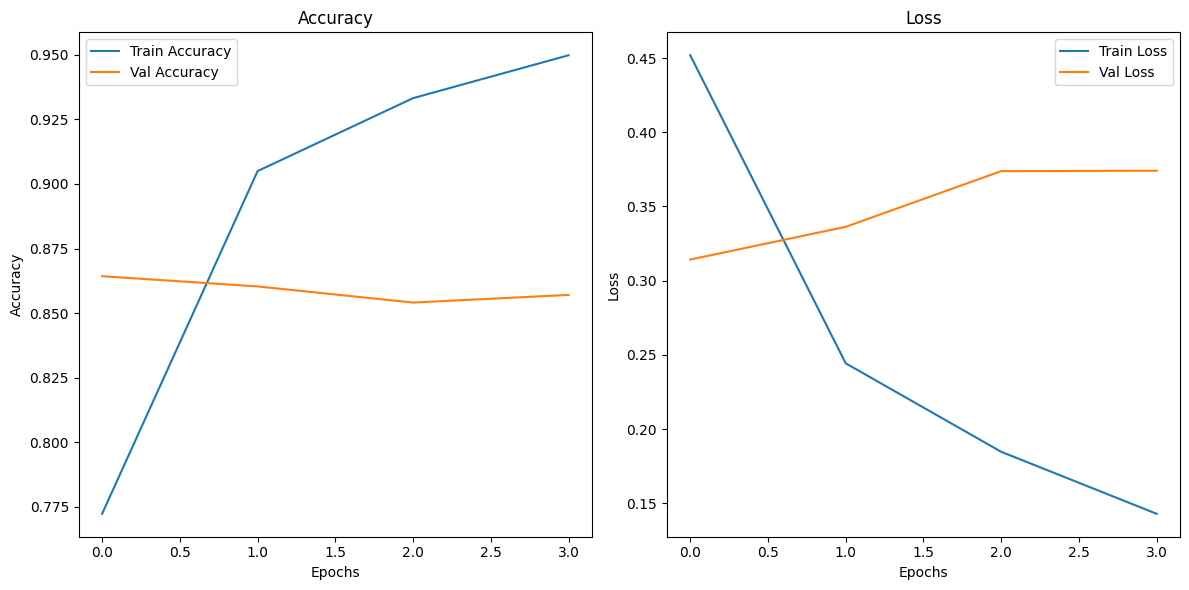

In [ ]:
def build_gru_model():
    dropout_rate = 0.5
    model_gru = Sequential()
    model_gru.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200))
    model_gru.add(Bidirectional(GRU(64, return_sequences=True)))
    model_gru.add(AttentionLayer(200))
    model_gru.add(Dense(64, activation='relu'))
    model_gru.add(Dropout(0.5, seed=seed_value))
    model_gru.add(Dense(32, activation='relu'))
    model_gru.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model_gru.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model_gru


early_stopping = EarlyStopping(
    monitor='val_loss', restore_best_weights=True, patience=3
)


embedding_dim = 300
learning_rate = 0.0005
gru_model = build_gru_model()
gru_history = gru_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, callbacks = early_stopping)
#gru_history = gru_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

test_loss, test_acc = gru_model.evaluate(x_test, y_test, batch_size=32)
print(f"GRU Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

L'ajout de ces nouvelles couches permet d'obtenir la meilleure accuracy tout en limitant le sur-apprentissage.

**Performance globale** : L'architecture retenue pour le GRU présente de meilleures performances que LSTM.


## 4) MLP

On passe ensuite à un modèle plus simple : le MultiLayer Perceptron. Il est constitué d'une **couche d'embedding** puis de **couches entièrement connectées**. On utilise **ReLU** en fonction d'activation pour éviter le vanishing gradient.
Contraitement aux méthodes précédentes, les MLP ne sont en théorie pas très adaptés à l'analyse de textes.

Après entraînement sans dropout, on remarque un fort sur-apprentissage. De même que pour les modèles précédents, on décide
donc d'appliquer un **dropout** de 50%, et de faire du **early stopping**.

On met le **learning rate à 0.0001**, ce qui est plutôt faible mais permet d'éviter de manquer un minimum.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5151 - loss: 0.6924 - val_accuracy: 0.6240 - val_loss: 0.6657
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7186 - loss: 0.5897 - val_accuracy: 0.8069 - val_loss: 0.4375
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8671 - loss: 0.3489 - val_accuracy: 0.8381 - val_loss: 0.3629
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9205 - loss: 0.2375 - val_accuracy: 0.8484 - val_loss: 0.3457
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9543 - loss: 0.1620 - val_accuracy: 0.8414 - val_loss: 0.3645
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9768 - loss: 0.1069 - val_accuracy: 0.8455 - val_loss: 0.3689
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8423 - loss: 0.3611
MLP Test Accuracy: 0.8484, Test Loss: 0.3457


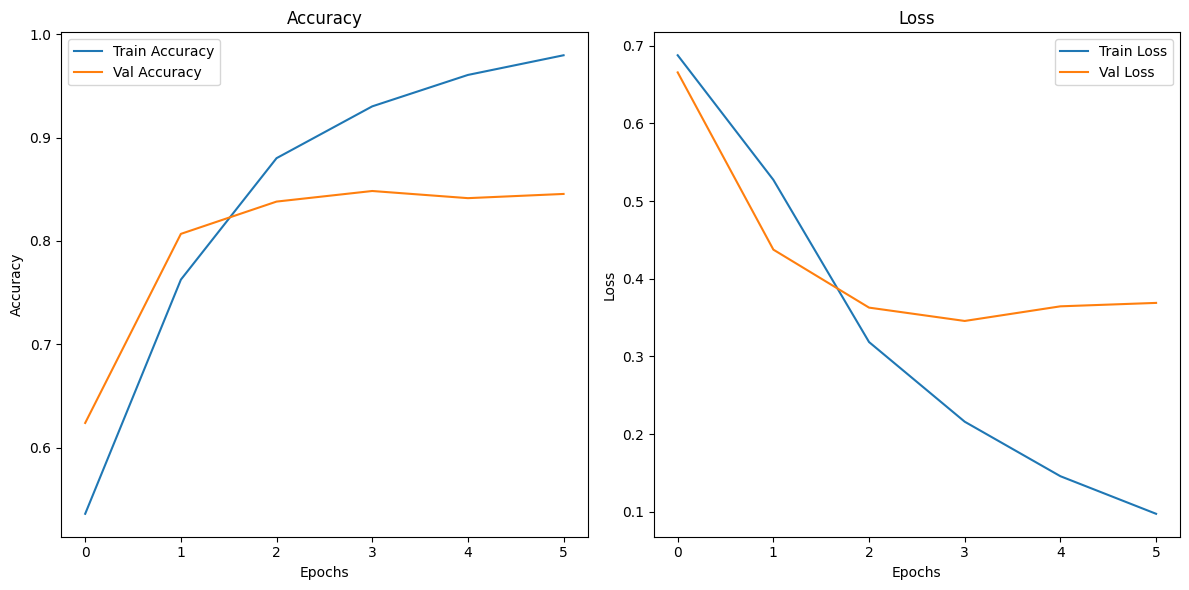

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_mlp_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.7),  # Ajout du Dropout pour régulariser le modèle
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

embedding_dim = 256
# EarlyStopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entraînement du modèle
mlp_model = build_mlp_model()
mlp_history = mlp_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=batch_size, callbacks=[early_stopping])

test_loss, test_acc = mlp_model.evaluate(x_test, y_test, batch_size=32)
print(f"MLP Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['accuracy'], label='Train Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['loss'], label='Train Loss')
plt.plot(mlp_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Performance globale** : La précision de test est de 84%, ce qui est proche de la précision obtenue avec un GRU. L'avantage de ce modèle plus simple est son temps d'entraînement (environ 3 à 6 secondes par epoch), plus court que celui des RNN.

## 5) CNN

Un modèle CNN est utilisé pour extraire des **motifs locaux** dans les **séquences de texte**.

Ce modèle comprend une couche d'**embedding**, une couche de **convolution** afin d'extraire les motifs locaux dans le texte (tels que les expressions clés, des phrases spécifiques,etc..) , un **max pooling**, et des **couches entièrement connectées**. On utilise une activation relu sur la dernière couche dense avant la couche de sortie.

On applique également du **dropout** et **early stopping** pour éviter le sur-apprentissage et améliorer la capacité de généralisation du modèle.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5095 - loss: 0.6931 - val_accuracy: 0.6780 - val_loss: 0.6765
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6540 - loss: 0.6506 - val_accuracy: 0.7335 - val_loss: 0.5443
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7448 - loss: 0.5312 - val_accuracy: 0.8042 - val_loss: 0.4358
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8049 - loss: 0.4330 - val_accuracy: 0.8326 - val_loss: 0.3803
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8476 - loss: 0.3635 - val_accuracy: 0.8490 - val_loss: 0.3458
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8768 - loss: 0.3042 - val_accuracy: 0.8578 - val_loss: 0.3251
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9019 - loss: 0.2532 - val_accuracy: 0.8597 - val_loss: 0.3193
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9266 - loss: 0.2078 - val_accuracy: 0

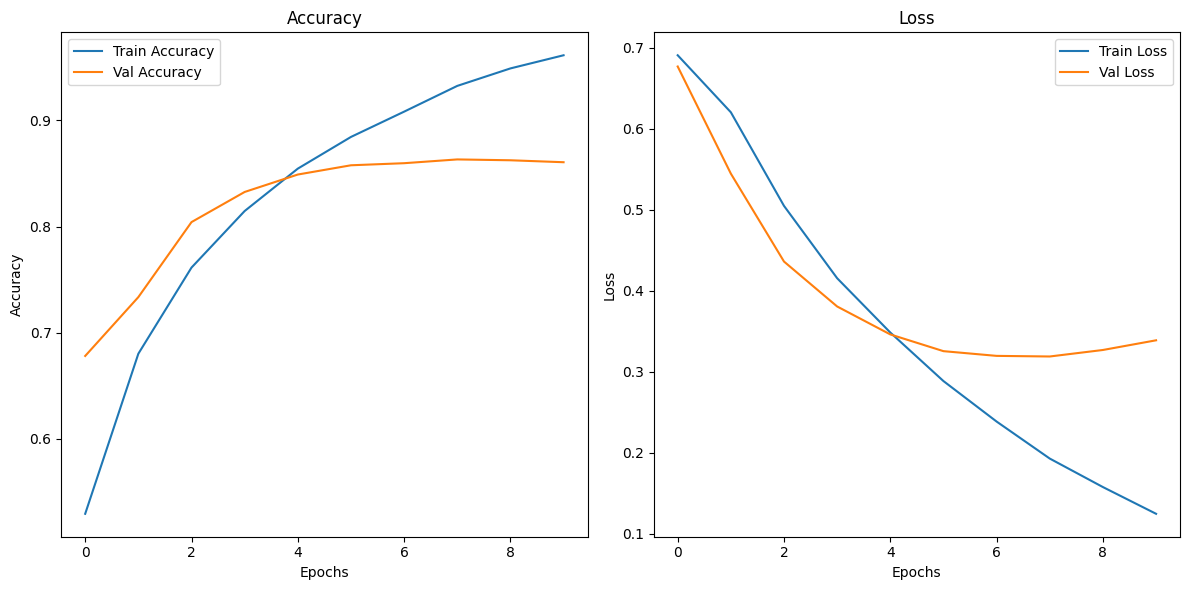

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),  # Ajout du Dropout pour régulariser
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# EarlyStopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=batch_size, callbacks=[early_stopping])

test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=32)
print(f"CNN Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5194 - loss: 0.6914 - val_accuracy: 0.7014 - val_loss: 0.6491
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6758 - loss: 0.6278 - val_accuracy: 0.7438 - val_loss: 0.5274
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7534 - loss: 0.5180 - val_accuracy: 0.8000 - val_loss: 0.4379
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8062 - loss: 0.4326 - val_accuracy: 0.8264 - val_loss: 0.3857
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8466 - loss: 0.3626 - val_accuracy: 0.8431 - val_loss: 0.3536
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8743 - loss: 0.3096 - val_accuracy: 0.8528 - val_loss: 0.3346
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9052 - loss: 0.2528 - val_accuracy: 0.8560 - val_loss: 0.3283
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9242 - loss: 0.2118 - val_accuracy: 0

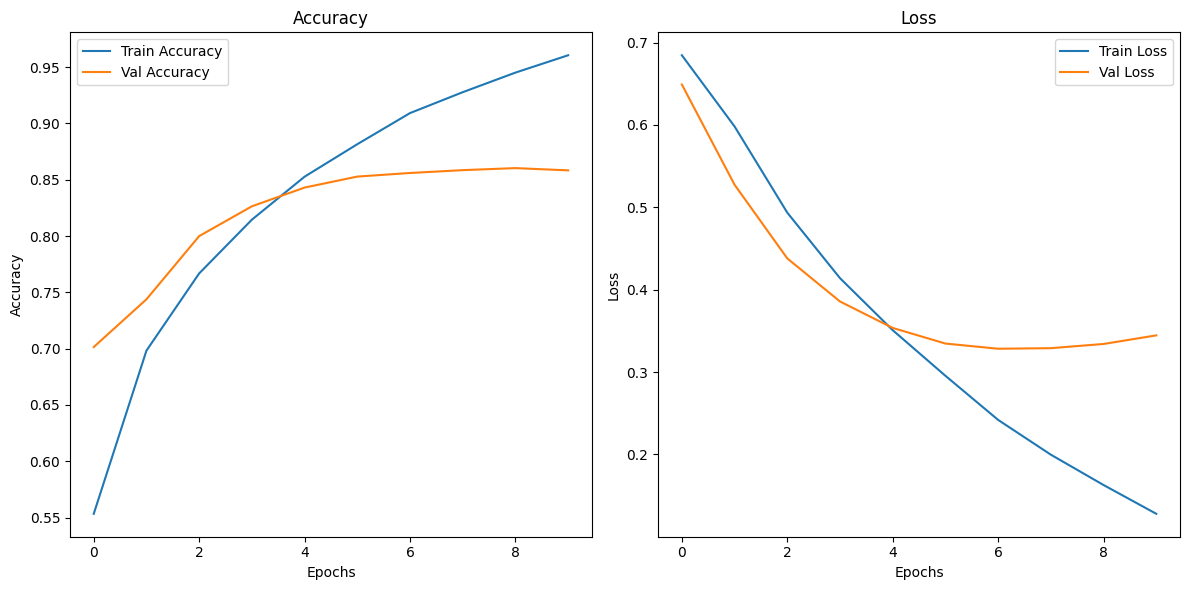

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

def build_cnn_updated_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200),
        Conv1D(128, 5),
        Activation('relu'),
        Conv1D(64, 3),
        Activation('relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64),
        Activation('relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# EarlyStopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=batch_size, callbacks=[early_stopping])

test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=32)
print(f"CNN Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

On observe qu'ajouter de la profondeur au CNN n'influe pas forcément sur les performances finales du modèles.


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5120 - loss: 0.6914 - val_accuracy: 0.6089 - val_loss: 0.6545 - learning_rate: 1.0000e-04
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6631 - loss: 0.6407 - val_accuracy: 0.7661 - val_loss: 0.4986 - learning_rate: 1.0000e-04
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7725 - loss: 0.4907 - val_accuracy: 0.8184 - val_loss: 0.4025 - learning_rate: 1.0000e-04
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8350 - loss: 0.3860 - val_accuracy: 0.8362 - val_loss: 0.3656 - learning_rate: 1.0000e-04
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8749 - loss: 0.3129 - val_accuracy: 0.8428 - val_loss: 0.3576 - learning_rate: 1.0000e-04
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9053 - loss: 0.2546 - val_accuracy: 0.8434 - val_loss: 0.3703 - learning_rate: 1.0000e-04
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy:

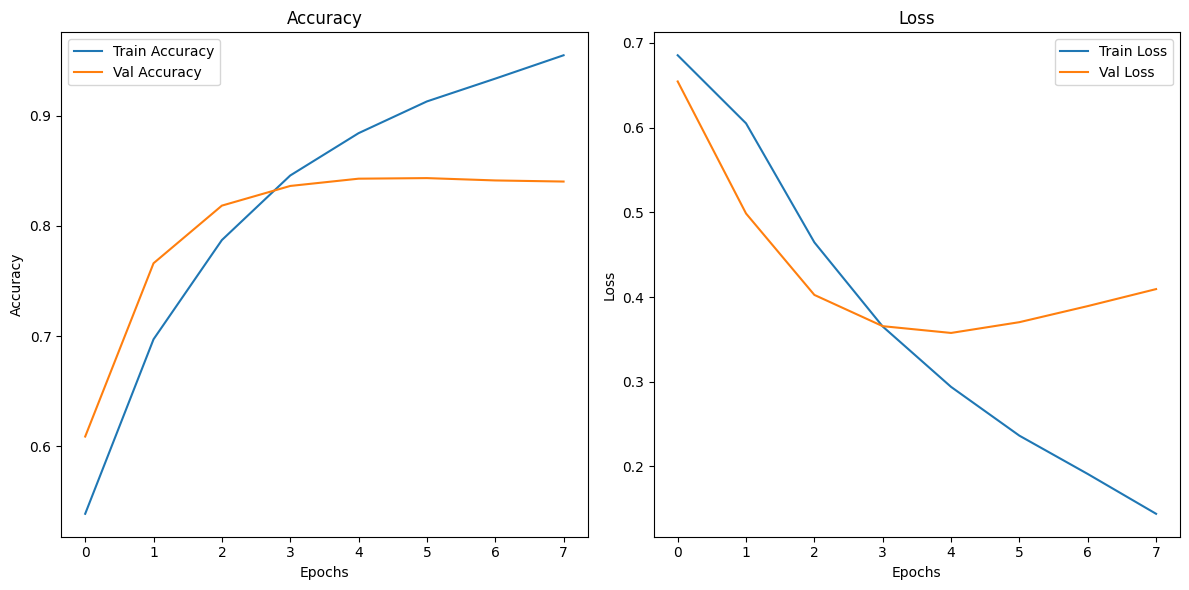

In [ ]:
def build_cnn_updated_model():
    model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=200),
    Conv1D(128, 5),
    Activation('relu'),
    Conv1D(64, 3),
    Activation('relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64),
    Activation('relu'),
    Dense(1, activation='sigmoid')
])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
# EarlyStopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
cnn_model = build_cnn_updated_model()
cnn_history = cnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=batch_size, callbacks=[early_stopping,lr_scheduler])

test_loss, test_acc = cnn_model.evaluate(x_test, y_test, batch_size=32)
print(f"CNN Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Avec une learning rate adaptive on obtient des performances similaires.  

Au final notre première architecture reste cohérente et utilisable au vu du peu d'améliorations qu'apportent nos modifications. On utilisera toutefois la plus précise des trois pour la prévision d'ensemble c'est à dire la première.

**Performance globale** : Le modèle atteint un bon niveau de précision, l'accuracy de test la plus haute jusque là avec un temps de calcul plus rapide que la plupart.

# III) Comparaison des modèles

### 1) Comparaison des performances

In [ ]:
models = {
    "RNN": rnn_model,
    "LSTM": model_single_lstm,
    "GRU": gru_model,
    "MLP": mlp_model,
    "CNN": cnn_model
}

for name, model in models.items():
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    print(f"{name} - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4126 - loss: 0.7193
RNN - Test Accuracy: 0.5561, Test Loss: 0.6867
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8770 - loss: 0.3388
LSTM - Test Accuracy: 0.8438, Test Loss: 0.3704
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8823 - loss: 0.2907
GRU - Test Accuracy: 0.8643, Test Loss: 0.3142
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.3609
MLP - Test Accuracy: 0.8484, Test Loss: 0.3457
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8531 - loss: 0.3494
CNN - Test Accuracy: 0.8633, Test Loss: 0.3186


En **terme de temps de calcul**, du plus rapide au plus lent, on a : MLP, CNN, GRU, LSTM et RNN.

Pour **l'empreinte mémoire**, on peut faire le classement suivant (de la plus grande à la plus petite) :
- LSTM : son architecture étant la plus complexe ;
- GRU : architecture complexe mais moins que LSTM (une porte en moins, pas de cellule mémoire)
- RNN : plus simple que LSTN et GRU
- CNN ;
- MLP : structure la plus simple, sans convolution complexe.

Sur la **précision**, on peut faire le classement suivant (du plus performante au moins performant) : CNN, GRU, MLP, LSTM et RNN.

**Comparaison générale** :

 1) CNN est un des modèles les plus performants avec une plus haute précision (86.33%). Il est également très rapide en termes de temps de calcul. Pour des données textuelles (classification binaire), le CNN détecte des motifs locaux (comme des combinaisons de mots ou des phrases courtes) qui peuvent être des indicateurs importants pour la tâche de classification de sentiment.

2) GRU est dans notre cas le modèle le plus précis(86.43%), avec une empreinte mémoire plus légère que LSTM. Les GRU sont plus rapides que les LSTM grâce à leur structure simplifiée, mais restent capables de traiter efficacement les informations séquentielles, ce qui les rend bien adaptés pour cette tâche. L' ajout d'une couche d'attention améliore les performances.

3) MLP est rapide et léger, avec une bonne précision, pour des tâches où les dépendances séquentielles ne sont pas essentielles.  Le MLP ne capture pas de manière native les dépendances à long terme entre les mots ou les éléments d'une séquence, ce qui peut limiter sa performance sur des tâches où la structure temporelle ou contextuelle est essentielle. Toutefois, il reste un modèle rapide et léger, ce qui explique son bon compromis entre précision (84%) et efficacité.

4) LSTM a également des bons résultats mais son empreinte mémoire est très importante, et manque de rapidité dans le temps de calculs. Les LSTM sont particulièrement puissants pour capturer des dépendances de long terme dans des séquences de données, cependant, pour des tâches simples comme celle-ci (classification binaire avec des données textuelles relativement simples), leur capacité à gérer des informations sur de longues séquences n’est peut-être pas autant nécessaire.

5) RNN offre des résultats moins précis que les autres modèles tout en ayant une empreinte mémoire plus importante que CNN et MLP. Cela s'explique car les RNN (modèles plus simples que les LSTM ou GRU), ont tendance à souffrir de problèmes comme le vanishing gradient, où les informations provenant des premières étapes de la séquence sont perdues au fur et à mesure du passage dans les couches. Bien que capables de traiter des séquences, ils ne sont pas aussi efficaces pour capturer des dépendances à long terme que les modèles LSTM et GRU.

### 2) Vote majoritaire

In [ ]:
def ensemble_predictions(models, x_data):
    predictions = [model.predict(x_data) for model in models.values()]
    # Convertir les probabilités en prédictions binaires
    binary_predictions = np.array([np.round(pred) for pred in predictions])
    # Appliquer le vote majoritaire
    final_predictions = np.mean(binary_predictions, axis=0) >= 0.5
    return final_predictions.astype(int)

# Générer des prédictions via ensemble
ensemble_preds = ensemble_predictions(models, x_test)

# Évaluer la précision de l'ensemble
ensemble_acc = np.mean(ensemble_preds.flatten() == y_test)
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Ensemble Accuracy: 0.8718


Le vote majoritaire mène à une précision finale de **87.18%**.


Le vote majoritaire a permis de **dépasser la précision individuelle** de tous les modèles, ce qui est un signe que la diversité des modèles amène à une **amélioration**.

Dans le cas du CNN et du GRU, ce modèle étant déjà plus performant, l'amélioration apportée est modeste. En revanche, cette nouvelle architecture a permis d'améliorer les résultats des autres modèles (comme le MLP, et surtout le RNN), qui avaient des performances plus faibles individuellement.

Ce résultat s'explique par **l'amélioration de la robustesse** grâce à l'assemblage des modèles. En combinant plusieurs modèles qui font des erreurs à différents moments (grâce à leur architecture et à leur biais d'apprentissage différents), on peut **réduire les erreurs globales** du système. Et cela permet d'augmenter la précision de l'ensemble.
